In [1]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_val_predict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline

from mne.decoding import CSP
from mne.channels import read_layout
from loaddata import *
from sklearn import metrics as met
from mne.channels import make_standard_montage

print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
fp = {
       'al' : {
          'cnt': '../DATA/Competencia BCI/III/Dataset IV/txt/al/100Hz/data_set_IVa_al_cnt.txt',
          'mrk': '../DATA/Competencia BCI/III/Dataset IV/txt/al/100Hz/data_set_IVa_al_mrk.txt',
          'lab': '../DATA/Competencia BCI/III/Dataset IV/txt/al/TRUE_LABELS.txt',
          'chn': '../DATA/Competencia BCI/III/Dataset IV/txt/al/100Hz/ch_names.txt',
          'pos':224,
          'freq': 100
       }
}

low_freq, high_freq = 7., 30.
tmin, tmax = 1., 2.

# event_id
event_id = {'right': 1, 'foot': 2}
    

In [3]:
sujeto = fp['al']
#Se carga set de datos crudos
raw = creatRawArray(sujeto)

#Seleccionamos los canales a utilizar
raw.pick_channels(['Fp1', 'Fp2', 'C3', 'C4','P7', 'P8', 'O1', 'O2'])

#Seteamos la ubicacion de los canales segun el 
montage = make_standard_montage('standard_1020')
raw.set_montage(montage)

print(raw.info)

#raw.plot_psd(fmax=50)
raw.plot(scalings='auto', n_channels=1, duration=50)

Creating RawArray with float64 data, n_channels=118, n_times=283574
    Range : 0 ... 283573 =      0.000 ...  2835.730 secs
Ready.
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, C3, C4, P7, P8, O1, O2
 chs: 8 EEG
 custom_ref_applied: False
 dig: 11 items (3 Cardinal, 8 EEG)
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 100.0 Hz
>


<Figure size 640x480 with 4 Axes>

<Figure size 640x480 with 4 Axes>

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 165 samples (1.650 sec)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, C3, C4, P7, P8, O1, O2
 chs: 8 EEG
 custom_ref_applied: False
 dig: 11 items (3 Cardinal, 8 EEG)
 highpass: 7.0 Hz
 lowpass: 30.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 100.0 Hz
>


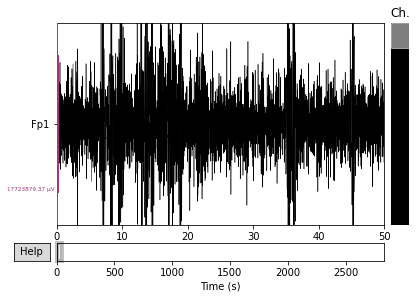

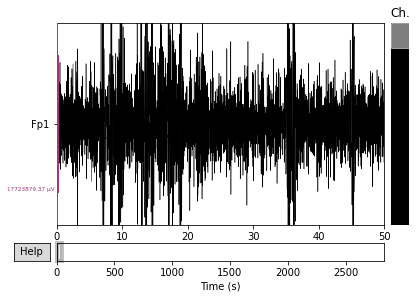

In [4]:
# Se aplica filtros band-pass
raw.filter(low_freq, high_freq, fir_design='firwin', skip_by_annotation='edge')
print(raw.info)
raw.plot(scalings='auto', n_channels=1, duration=50)

In [5]:
#Se carga eventos
events, labels = creatEventsArray(sujeto)

#Se genera las epocas con los datos crudos y los eventos
epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True,
                verbose=False)

#Se carga labels (convierte 1 -> -1 y 2 -> 0 )
labels = epochs.events[:, -1] - 2

140 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


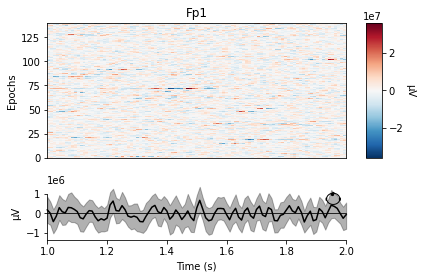

140 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


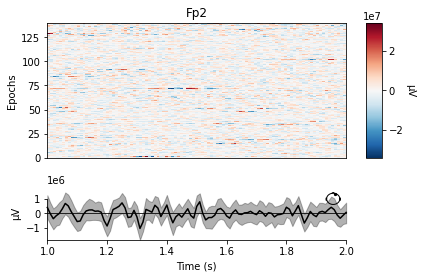

140 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


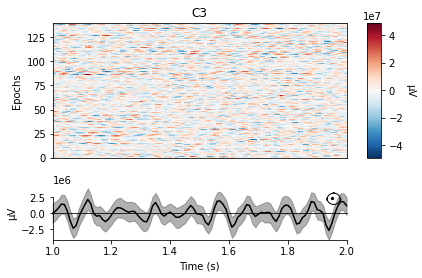

140 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


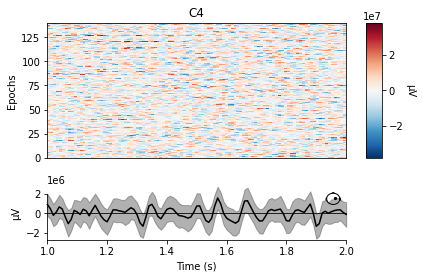

140 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


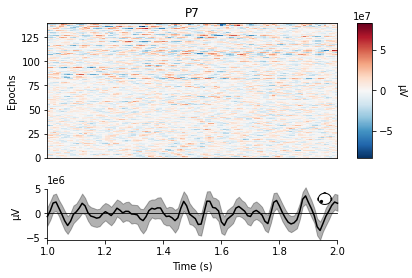

140 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


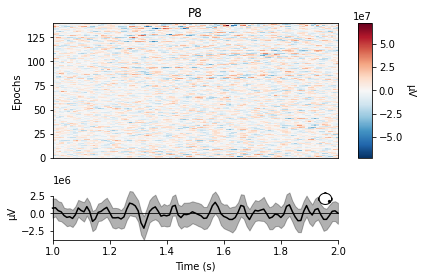

140 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


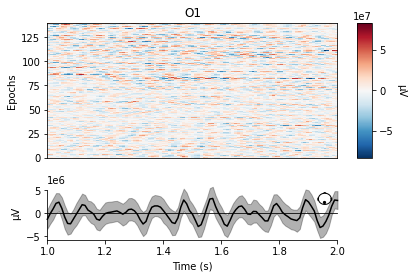

140 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


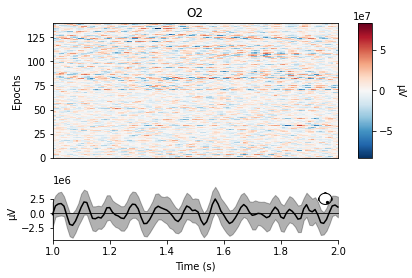

[<Figure size 432x288 with 4 Axes>]

In [6]:
#print(epochs)
epoch_right = epochs['right']
epoch_foot =epochs['foot']

#raw.pick_channels(['Fp1', 'Fp2', 'C3', 'C4','P7', 'P8', 'O1', 'O2'])
"""
epoch_right.plot_image(picks=['Fp1'])
epoch_right.plot_image(picks=['Fp2'])
epoch_right.plot_image(picks=['C3'])
epoch_right.plot_image(picks=['C4'])
epoch_right.plot_image(picks=['P7'])
epoch_right.plot_image(picks=['P8'])
epoch_right.plot_image(picks=['O1'])
epoch_right.plot_image(picks=['O2'])
"""
epoch_foot.plot_image(picks=['Fp1'])
epoch_foot.plot_image(picks=['Fp2'])
epoch_foot.plot_image(picks=['C3'])
epoch_foot.plot_image(picks=['C4'])
epoch_foot.plot_image(picks=['P7'])
epoch_foot.plot_image(picks=['P8'])
epoch_foot.plot_image(picks=['O1'])
epoch_foot.plot_image(picks=['O2'])

<Epochs  |   280 events (all good), 1 - 2 sec, baseline off, ~1.8 MB, data loaded,
 'foot': 140
 'right': 140>
<Epochs  |   140 events (all good), 1 - 2 sec, baseline off, ~912 kB, data loaded,
 'right': 140>
<Evoked  |  'right' (average, N=140), [1, 2] sec, 8 ch, ~34 kB>
combining channels using "gfp"
combining channels using "gfp"


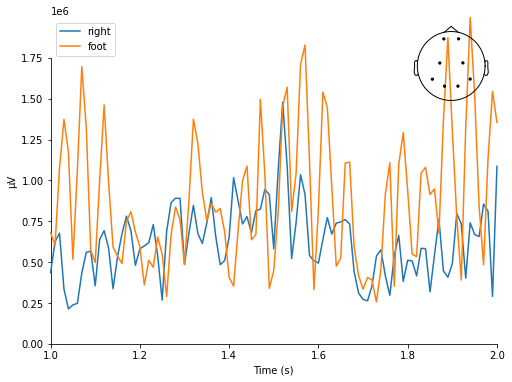

[<Figure size 576x432 with 2 Axes>]

In [7]:
#Estimamos el evoked caracteristico, haciendo promedio del epoch
right_evoked = epoch_right.average()
foot_evoked = epoch_foot.average()

print(epochs)
print(epoch_right)
print(right_evoked)

mne.viz.plot_compare_evokeds(dict(right=right_evoked, foot=foot_evoked),
                             legend=True, show_sensors=True)



In [8]:
#Lo convierte a matriz numpy
epochs_data = epochs.get_data()

#Se crea set de de pruebas y test
train_x=epochs_data[:sujeto['pos']]
train_y=labels[:sujeto['pos']]

test_x =epochs_data[sujeto['pos']:]
test_y=labels[sujeto['pos']:]

print(train_x.shape)
print(test_x.shape)

(224, 8, 101)
(56, 8, 101)


In [9]:
#Clasificadores del modelo
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=8, reg=None, log=True, norm_trace=False)

#Modelo utiliza CSP y LDA
clf = Pipeline([('CSP', csp), ('LDA', lda)])

#Entrenamiento del modelo
clf.fit(train_x, train_y)
score = clf.score(train_x, train_y)

#Cross-Validation
scores_val = cross_val_score(clf, train_x, train_y, cv=5, n_jobs=1, verbose=False)

print("Metrica del modelo:", score)
print("Metricas cross_validation:", scores_val)
print("Media de cross_validation:", scores_val.mean())

Computing rank from data with rank=None
    Using tolerance 3.8 (2.2e-16 eps * 8 dim * 2.2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.9 (2.2e-16 eps * 8 dim * 2.2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5 (2.2e-16 eps * 8 dim * 2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5 (2.2e-16 eps * 8 dim * 2e+15  max singular value)
    Estimated rank (mag): 8
    MAG: ra

In [10]:
#Resultados
result=clf.predict(test_x)

print( met.confusion_matrix(test_y, result) )
print( "Recall: ", met.recall_score(test_y, result, average=None) )
print( "Precision: ", met.precision_score(test_y, result, average=None) )
print( "F1: ", met.f1_score(test_y, result, average=None) )
print( "Acurracy: ", met.accuracy_score(test_y, result) )

tn, fp, fn, tp = met.confusion_matrix(test_y, result).ravel()
print(tn, fp, fn, tp)

print(met.classification_report(test_y, result))

[[23  5]
 [ 3 25]]
Recall:  [0.82142857 0.89285714]
Precision:  [0.88461538 0.83333333]
F1:  [0.85185185 0.86206897]
Acurracy:  0.8571428571428571
23 5 3 25
              precision    recall  f1-score   support

          -1       0.88      0.82      0.85        28
           0       0.83      0.89      0.86        28

    accuracy                           0.86        56
   macro avg       0.86      0.86      0.86        56
weighted avg       0.86      0.86      0.86        56



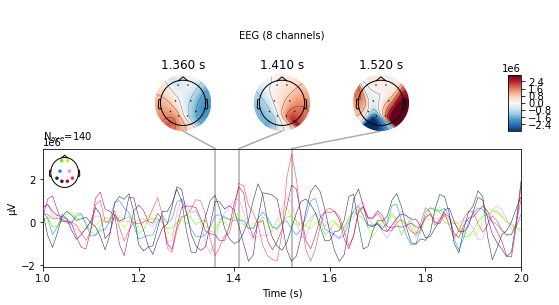

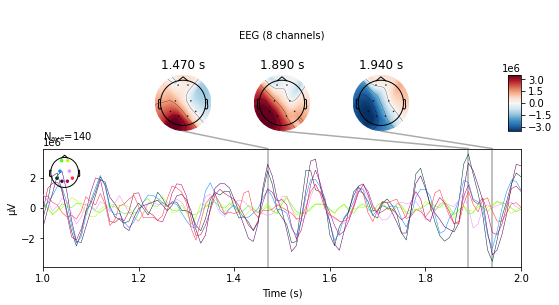

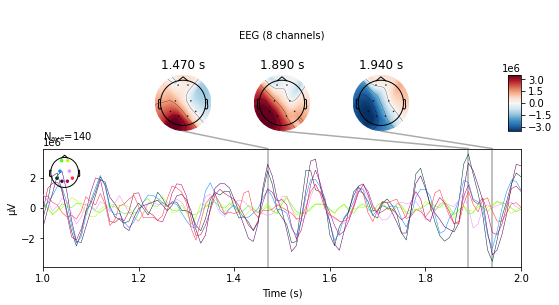

In [11]:
right_evoked.plot_joint()
foot_evoked.plot_joint()
#right_evoked.plot_topomap(times=[1, 1.5, 2])
#foot_evoked.plot_topomap(times=[1, 1.5, 2])